In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
v = pd.read_csv('/home/mimimustaine/Downloads/Análisis_de_datos/da2019-MIMIMUSTAINE/Semana14/Trabajo/NOAO_Data_Lab/result_7', encoding = "ISO-8859-1", engine='python')
v.head()

,allmask_g,allmask_r,allmask_z,anymask_g,anymask_r,anymask_z,brickid,brickname,brick_primary,brightstarinblob,...,snr_w4,snr_z,type,w1_w2,w2_w3,w3_w4,wise_coadd_id,wisemask_w1,wisemask_w2,z_w1
0,0,0,0,0,0,0,475175,3299p257,1,0,...,-0.203402,12.13880,PSF,-1.37254,NaN,NaN,3300p257,0,0,1.08618
1,0,0,0,0,0,0,475175,3299p257,1,0,...,2.164960,8.06203,PSF,NaN,NaN,4.71022,3300p257,0,0,NaN
2,0,0,0,0,0,0,475175,3299p257,1,0,...,-2.258560,16.66540,PSF,NaN,NaN,NaN,3300p257,0,0,NaN
3,0,0,0,0,0,0,475175,3299p257,1,0,...,-4.090530,35.12620,PSF,NaN,5.56772,NaN,3300p257,0,0,NaN
4,0,0,0,0,0,0,475175,3299p257,1,0,...,0.048777,6.16678,REX,NaN,NaN,0.62468,3300p257,0,0,NaN


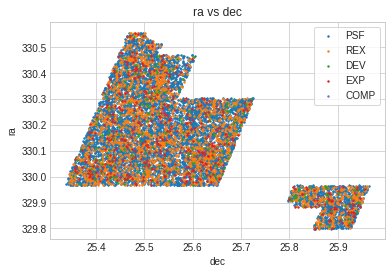

In [3]:
#Tipos de estrellas
tipos = v['type'].unique()
tipos

for i in range(len(tipos)):
    plt.scatter(v['dec'][v['type'] == tipos[i]], v['ra'][v['type'] == tipos[i]], s = 2.0, label = '{}'.format(tipos[i]))
plt.title('ra vs dec')
plt.xlabel('dec')
plt.ylabel('ra')
plt.legend(frameon = True, loc = 'best')
plt.show()

### <strong>Tranformación</strong>

In [4]:
#Primero hay que transformar de grados a radianes:
def ang(angulo):
    return (angulo * np.pi) / 180

In [55]:
#Número de datos
N = 100
#Generación de ángulos random
cos_decr = []

for i in range(N):
    cos_decr.append(np.random.uniform(np.cos(ang(25.3)), np.cos(ang(25.7)))) #para dec
#for i in range(10):
#    ang_r[i].append(ang(np.random.uniform(329.9, 330.5))) #para ra

#Generación de puntos random en coordenadas cartesianas:
x_r, y_r, z_r = [], [], []
for i in range(N):
    ra_r = np.random.uniform(ang(np.min(v['ra'])), ang(np.max(v['ra'])))
    x_r.append(np.cos(ra_r) * np.sqrt(1 - cos_decr[i] ** 2))
    y_r.append(np.sin(ra_r) * np.sqrt(1 - cos_decr[i] ** 2))
    z_r.append(cos_decr[i])

In [56]:
#Tranformación de los ángulos en datos a coordenadas cartesianas:
x_o, y_o, z_o = [], [], []
for i in range(N):
    x_o.append(np.cos(ang(v['ra'][i])) * np.sin(ang(v['dec'][i])))
    y_o.append(np.sin(ang(v['ra'][i])) * np.sin(ang(v['dec'][i])))
    z_o.append(np.cos(ang(v['dec'][i])))

Proyección de los puntos random producidos comparados con las observaciones:

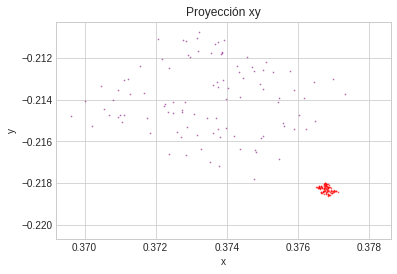

In [58]:
plt.scatter(x_o, y_o, alpha = 0.6, s = 0.5, color = 'red')
plt.scatter(x_r, y_r, alpha = 0.5, s = 0.5, color = 'purple')
plt.title('Proyección xy')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

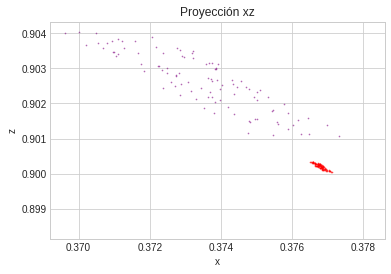

In [59]:
plt.scatter(x_o, z_o, alpha = 0.6, s = 0.5, color = 'red')
plt.scatter(x_r, z_r, alpha = 0.5, s = 0.5, color = 'purple')
plt.title('Proyección xz')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

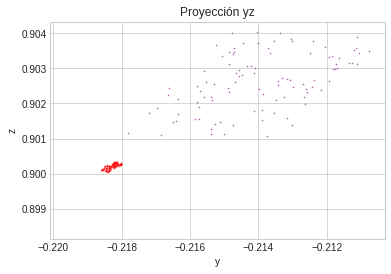

In [60]:
plt.scatter(y_o, z_o, alpha = 0.6, s = 0.5, color = 'red')
plt.scatter(y_r, z_r, alpha = 0.5, s = 0.5, color = 'purple')
plt.title('Proyección yz')
plt.xlabel('y')
plt.ylabel('z')
plt.show()

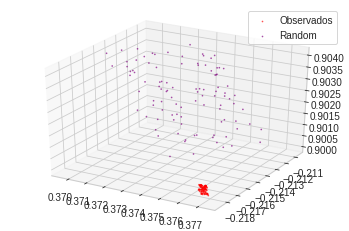

In [63]:
ax = plt.axes(projection='3d')
ax.scatter(x_o, y_o, z_o, s = 0.5, alpha = 0.6, color = 'red', label = 'Observados')
ax.scatter(x_r, y_r, z_r, s = 0.5, alpha = 0.6, color = 'purple', label = 'Random')
ax.legend(frameon = True)

### <strong>Algoritmo para la función de correlación</strong>

Funciones para determinar las distancias entre <strong>observados-observados, observados-random, random-random,</strong> función de correlación.

In [44]:
def distance(v1, v2):
    return np.sqrt((v1[0] - v2[0]) ** 2 + (v1[1] - v2[1]) ** 2 + (v1[2] - v2[2]) ** 2)

#Función para combinaciones de los elementos del mismo arreglo:
def f1(v, N):
    a = [] #auxiliar
    for i in range(N):
        for j in range(N):
            if j > i:
                a.append(distance(v[i], v[j]))
    return a

#Función para combinaciones de los elementos de dos arreglos:
def f2(v1, v2, N1, N2):
    a = [] #auxiliar
    for i in range(N1):
        for j in range(N2):
                a.append(distance(v1[i], v2[j]))
    return a

def correlacion(obs, ran):
    #Se guardarán en un arreglo cada uno de los resultados:
    #Se nombra a los arreglos:
    # **********obs, ran = np.array([x_o, y_o, z_o].T), np.array([x_r, y_r, z_r].T)********** #
    #observado-observado, observado-random, random-random
    o_o, o_r, r_r = f1(obs, len(obs)), f2(obs, ran, len(obs), len(ran)), f1(ran, len(ran))

    #Para la función de correlación:
    o_of = np.sum(o_o) / (len(obs) * (len(obs) - 1) / 2)
    o_rf = np.sum(o_r) / (len(obs) * len(ran))
    r_rf = np.sum(r_r) / (len(ran) * (len(ran) - 1) / 2)
    return (o_of - 2 * o_rf + r_rf) / r_rf

Información que necesito para recordar que pasé de manera correcta los argumentos.

In [64]:
len(np.array([x_o, y_o, z_o]).T)

100

Prueba de las funciones:

In [69]:
print(distance(np.array([x_o, y_o, z_o]), np.array([x_r, y_r, z_r])))

[0.00874959 0.00598597 0.00517541 0.00748159 0.00797924 0.00844993
 0.00429919 0.00210258 0.00734711 0.00664701 0.00317337 0.00914139
 0.00820229 0.00793205 0.00603804 0.0071271  0.00658307 0.00455945
 0.00880007 0.00399205 0.00711209 0.00459988 0.00499249 0.00804423
 0.00626199 0.00614059 0.00650255 0.0064098  0.00820192 0.00625056
 0.00666413 0.00306817 0.00748213 0.00494919 0.00545786 0.00794678
 0.00564463 0.00327797 0.00218509 0.00779292 0.00811905 0.0089367
 0.00891971 0.0036114  0.0063514  0.00587201 0.00824782 0.00649155
 0.00466216 0.00840726 0.00836075 0.00599615 0.00512517 0.00341464
 0.00851197 0.00396642 0.00676442 0.00813072 0.00865689 0.00647017
 0.00887823 0.00512473 0.0032136  0.00621352 0.00684354 0.00581954
 0.00811636 0.00552035 0.00804897 0.0084522  0.00397841 0.00568249
 0.00489892 0.00674039 0.0039273  0.00660601 0.0062768  0.00735894
 0.0065174  0.00876914 0.00576607 0.0031387  0.00272299 0.00723105
 0.00511107 0.00589225 0.00869626 0.00321725 0.00822511 0.00627

In [72]:
len(f1(np.array([x_o, y_o, z_o]).T, len(np.array([x_o, y_o, z_o]).T)))

4950

In [73]:
correlacion(np.array([x_o, y_o, z_o]).T, np.array([x_r, y_r, z_r]).T)

-2.79043726580022

<strong>Prueba de funcionamiento de la función CORRELACIÓN:</strong>

In [74]:
#Generación de puntos random (2) en coordenadas cartesianas:
x_r1, y_r1, z_r1 = [], [], []
for i in range(N):
    ra_r1 = np.random.uniform(ang(np.min(v['ra'])), ang(np.max(v['ra'])))
    x_r1.append(np.cos(ra_r1) * np.sqrt(1 - cos_decr[i] ** 2))
    y_r1.append(np.sin(ra_r1) * np.sqrt(1 - cos_decr[i] ** 2))
    z_r1.append(cos_decr[i])
    
correlacion(np.array([x_r, y_r, z_r]).T, np.array([x_r1, y_r1, z_r1]).T)

0.013228954376200489

Si no existe ningún tipo de relación entre los números random producidos, entonces el valor anterior debería ser cero.